To implement RADAR for detecting AI-generated text:
1. Prompt large language models to rewrite text using rewriting prompts like "Help me polish this" or "Rewrite this for me" to gain contextual information for accurate detection 
2. Calculate the editing distance, such as the Levenshtein score, between the original and rewritten text to measure the modifications made by the model 
3. Utilize the differences in invariance, equivariance, and uncertainty to make predictions for detecting AI-generated content 
4. Combine features of invariance, equivariance, and uncertainty to enhance detection performance 

In [4]:
! pip install pandas
! pip -q install matplotlib
! pip -q install seaborn
! pip install numpy
! pip install transformers
! pip install tqdm

In [58]:
import pandas as pd
#AI (1) and Human (0)
df= pd.read_csv("AI_Human.csv")
df.head(5)

In [60]:
count_zeros = df[df['generated'] == 0.0].shape[0]
print("Number of rows with 'generated' value of 0:", count_zeros)

Number of rows with 'generated' value of 0: 305797


In [61]:
zero_generated_rows = df[df['generated'] == 0.0]

# Sample 50,000 rows randomly from the subset
sampled_rows = zero_generated_rows.sample(n=10000, random_state=42)

# Display the sampled rows
sampled_rows.head()

,text,generated
260481,Do curfews keep teenagers from Getting into tr...,0.0
133303,"In this article ""The Challenge of Exploring Ve...",0.0
291551,With THP rapid growth of THP Internet in recen...,0.0
451335,The electoral College is the way Us United Sta...,0.0
461660,This technology of you can calculate the emoti...,0.0


Rewrite Human text using BART

In [6]:
'''
import torch
import pandas as pd
from transformers import BartForConditionalGeneration, BartTokenizer
human_text_df = sampled_rows
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained BART model and tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

# Define a function to regenerate text using BART
def regenerate_text(text):
    # Truncate input text if it exceeds maximum sequence length
    max_seq_length = tokenizer.model_max_length - 2  # Subtract 2 for the [CLS] and [SEP] tokens
    truncated_text = text[:max_seq_length]

    # Tokenize input text
    input_ids = tokenizer(truncated_text, return_tensors="pt").input_ids.to(device)

    # Generate text using BART
    output_ids = model.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)

    # Decode generated text
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return generated_text


# Regenerate human text and create a new DataFrame
regenerated_text_list = []
for text in human_text_df['text']:
    regenerated_text = regenerate_text(text)
    regenerated_text_list.append(regenerated_text)

regenerated_text_df = pd.DataFrame({'regenerated_text': regenerated_text_list})

# Combine the regenerated text with the original DataFrame
regenerated_df = pd.concat([human_text_df.reset_index(drop=True), regenerated_text_df], axis=1)

# Save the regenerated DataFrame to a new CSV file
regenerated_df.to_csv("Generation_Step1.csv", index=False)

'''

'\nimport torch\nimport pandas as pd\nfrom transformers import BartForConditionalGeneration, BartTokenizer\nhuman_text_df = sampled_rows\n# Check if GPU is available\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nprint("Using device:", device)\n\n# Load pre-trained BART model and tokenizer\nmodel_name = "facebook/bart-large-cnn"\ntokenizer = BartTokenizer.from_pretrained(model_name)\nmodel = BartForConditionalGeneration.from_pretrained(model_name).to(device)\n\n# Define a function to regenerate text using BART\ndef regenerate_text(text):\n    # Truncate input text if it exceeds maximum sequence length\n    max_seq_length = tokenizer.model_max_length - 2  # Subtract 2 for the [CLS] and [SEP] tokens\n    truncated_text = text[:max_seq_length]\n\n    # Tokenize input text\n    input_ids = tokenizer(truncated_text, return_tensors="pt").input_ids.to(device)\n\n    # Generate text using BART\n    output_ids = model.generate(input_ids, max_length=100, num_beams=4, ear

In [5]:
regenerated_df= pd.read_csv("Generation_Step1.csv")
regenerated_df = regenerated_df.rename(columns={'regenerated_text': 'BART_Text'})
regenerated_df = regenerated_df.rename(columns={'text': 'Human_text'})
regenerated_df  = regenerated_df .drop(columns=['generated'])
regenerated_df.head()

,Human_text,BART_Text
0,Do curfews keep teenagers from Getting into tr...,The city council is currently debating on whet...
1,"In this article ""The Challenge of Exploring Ve...",Venus is the closest planet to Earth in terms ...
2,With THP rapid growth of THP Internet in recen...,ThP question of whether or not school should e...
3,The electoral College is the way Us United Sta...,The electoral College is the way Us United Sta...
4,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...


In [45]:
import pandas as pd
import Levenshtein as lev
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

df = regenerated_df

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Function to calculate Levenshtein distance
def calculate_editing_distance(original_text, rewritten_text):
    tfidf_original = vectorizer.fit_transform([original_text])
    tfidf_rewritten = vectorizer.transform([rewritten_text])
    
    # Convert TF-IDF vectors to dense arrays
    original_array = tfidf_original.toarray()[0]
    rewritten_array = tfidf_rewritten.toarray()[0]
    
    # Calculate Levenshtein distance on dense arrays
    return lev.distance(original_array, rewritten_array)

# Function to calculate statistics
def calculate_summary_statistics(df):
    invariance_values = []
    equivariance_values = []
    uncertainty_values = []
    
    for _, row in df.iterrows():
        human_text = row['Human_text']
        bart_text = row['BART_Text']
        
        # Calculate editing distance
        editing_distance = calculate_editing_distance(human_text, bart_text)
        
        # Invariance
        if editing_distance == 0:
            invariance_values.append(1)
        else:
            invariance_values.append(0)
        
        # Equivariance
        if editing_distance == 0:
            equivariance_values.append(0)
        else:
            equivariance_values.append(1)
        
        # Uncertainty
        uncertainty_values.append(editing_distance)
    
    mean_invariance = np.mean(invariance_values)
    mean_equivariance = np.mean(equivariance_values)
    mean_uncertainty = np.mean(uncertainty_values)
    
    return mean_invariance, mean_equivariance, mean_uncertainty

# Compute statistics for the entire dataset
mean_invariance, mean_equivariance, mean_uncertainty = calculate_summary_statistics(df)

print("Mean Invariance:", mean_invariance)
print("Mean Equivariance:", mean_equivariance)
print("Mean Uncertainty (Levenshtein Distance):", mean_uncertainty)


Mean Invariance: 0.0
Mean Equivariance: 1.0
Mean Uncertainty (Levenshtein Distance): 172.6257


1. Regenerate Responses Based on Prompts for HUMAN_TEXT

In [10]:
HUMAN_TEXT = regenerated_df.copy()
HUMAN_TEXT  = HUMAN_TEXT .drop(columns=['BART_Text'])
HUMAN_TEXT = HUMAN_TEXT.iloc[10:15]
HUMAN_TEXT.shape

(5, 1)

In [ ]:

import pandas as pd
import torch
from transformers import BartForConditionalGeneration, BartTokenizer
from tqdm import tqdm

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BART model and tokenizer on the specified device
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

# Define the prompts with corresponding column names
prompts = [
    ("Rephrase my text", "BART_rephrase"),
    ("Help me refine this", "BART_refine"),
    ("Make this clearer", "BART_clear"),
    ("Please make this more concise", "BART_concise"),
    ("Humanize the text", "BART_Humanize")
    #("Improve the structure of this text", "BART_structure"),
    #("Enhance the readability of this passage", "BART_readability"),
    #("Simplify this text", "BART_simplify"),
    #("Refine the language used here", "BART_language")
    #("Could you polish this for me?", "BART_polish"),
]

# Function to generate BART response for a given human_text and prompt
def generate_bart_response(human_text, prompt):
    input_text = f"{prompt}: {human_text}"
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    output_ids = model.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)
    bart_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return bart_text

# Example DataFrame (replace this with your actual DataFrame)
df =HUMAN_TEXT

# Initialize columns for each generated BART response based on prompts
for prompt_text, column_name in prompts:
    df[column_name] = ""

# Iterate over each row in the DataFrame with tqdm for progress tracking
for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating BART responses"):
    human_text = row['Human_text']
    # Iterate over each predefined prompt and generate corresponding BART response
    for prompt_text, column_name in prompts:
        # Generate BART response using the specified prompt and human text
        bart_response = generate_bart_response(human_text, prompt_text)
        # Store the generated BART response in the DataFrame column corresponding to the prompt
        df.at[index, column_name] = bart_response

# Display the updated DataFrame with generated BART response columns
print(df)

# Save the DataFrame to a CSV file
output_file = "generated_bart_responses.csv"
df.to_csv(output_file, index=False)

print(f"DataFrame with generated BART responses saved to '{output_file}'")

2. Generate BART Responses for the same prompts for rewritten text by LLM

In [13]:
regenerated_df= pd.read_csv("regenerated_text.csv")
regenerated_df = regenerated_df.rename(columns={'regenerated_text': 'BART_Text'})
regenerated_df = regenerated_df.rename(columns={'text': 'Human_text'})
regenerated_df  = regenerated_df .drop(columns=['generated'])
regenerated_df.head()

,Human_text,BART_Text
0,Do curfews keep teenagers from Getting into tr...,The city council is currently debating on whet...
1,"In this article ""The Challenge of Exploring Ve...",Venus is the closest planet to Earth in terms ...
2,With THP rapid growth of THP Internet in recen...,ThP question of whether or not school should e...
3,The electoral College is the way Us United Sta...,The electoral College is the way Us United Sta...
4,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...


In [19]:
BART_TEXT = regenerated_df.copy()
BART_TEXT  = BART_TEXT .drop(columns=['Human_text'])
BART_TEXT = BART_TEXT.head(10)
BART_TEXT.shape

(10, 1)

In [20]:
'''
import pandas as pd
import torch
from transformers import BartForConditionalGeneration, BartTokenizer
from tqdm import tqdm

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BART model and tokenizer on the specified device
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

# Define the prompts with corresponding column names
prompts = [
    ("Rephrase my text", "BART_rephrase"),
    ("Help me refine this", "BART_refine"),
    ("Make this clearer", "BART_clear"),
    ("Please make this more concise", "BART_concise"),
    ("Humanize the text", "BART_Humanize")
    #("Improve the structure of this text", "BART_structure"),
    #("Enhance the readability of this passage", "BART_readability"),
    #("Simplify this text", "BART_simplify"),
    #("Refine the language used here", "BART_language")
    #("Could you polish this for me?", "BART_polish"),
]

# Function to generate BART response for a given human_text and prompt
def generate_bart_response(human_text, prompt):
    input_text = f"{prompt}: {human_text}"
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    output_ids = model.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)
    bart_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return bart_text

# Example DataFrame (replace this with your actual DataFrame)
df = BART_TEXT

# Initialize columns for each generated BART response based on prompts
for prompt_text, column_name in prompts:
    df[column_name] = ""

# Iterate over each row in the DataFrame with tqdm for progress tracking
for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating BART responses"):
    human_text = row['BART_Text']
    # Iterate over each predefined prompt and generate corresponding BART response
    for prompt_text, column_name in prompts:
        # Generate BART response using the specified prompt and human text
        bart_response = generate_bart_response(human_text, prompt_text)
        # Store the generated BART response in the DataFrame column corresponding to the prompt
        df.at[index, column_name] = bart_response

# Display the updated DataFrame with generated BART response columns
print(df)

# Save the DataFrame to a CSV file
output_file = "BART Text_Generated Bart Responses.csv"
df.to_csv(output_file, index=False)

print(f"DataFrame with generated BART responses saved to '{output_file}'")
'''

Generating BART responses: 100%|██████████| 10/10 [03:26<00:00, 20.65s/it]


                                           BART_Text  \
0  The city council is currently debating on whet...   
1  Venus is the closest planet to Earth in terms ...   
2  ThP question of whether or not school should e...   
3  The electoral College is the way Us United Sta...   
4  This technology of you can calculate the emoti...   
5  One way that this facial coding machine can al...   
6  The Face on Mars had no alien help to be forme...   
7  "The Challenge of Exploring Venus", suggests t...   
8  NASA's Viking 1 spacecraft was circling the pl...   
9  In the article "The Challenge of Exploring Ven...   

                                       BART_rephrase  \
0  The city council is debating whether to adopt ...   
1  Venus is the closest planet to Earth in terms ...   
2  ThP question of whether or not school should e...   
3  Rephrase my text: The electoral College is the...   
4  This technology of you can calculate the emoti...   
5  A facial coding machine can also Yelp. It ca

In [56]:
import pandas as pd

# Example DataFrame structure for human-generated text (adjust as per your actual data)
human_text_df = pd.read_csv("Human Text_Generated Bart Responses.csv")
# Example DataFrame structure for BART-generated text (adjust as per your actual data)
bart_text_df = pd.read_csv("BART Text_Generated Bart Responses.csv")

# Define a function to combine human and BART text rows along with responses
def combine_rows(human_df, bart_df):
    combined_rows = []
    
    # Assuming the number of rows in both DataFrames is the same
    for idx in range(len(human_df)):
        # Get human-generated text and responses
        human_text = human_df.loc[idx, 'Human_text']
        human_responses = human_df.loc[idx, ['BART_rephrase', 'BART_refine', 'BART_clear', 'BART_concise', 'BART_Humanize']]
        
        # Get BART-generated text and responses
        bart_text = bart_df.loc[idx, 'BART_Text']
        bart_responses = bart_df.loc[idx, ['BART_rephrase', 'BART_refine', 'BART_clear', 'BART_concise', 'BART_Humanize']]
        
        # Append human-generated row with label 0
        combined_rows.append([human_text] + human_responses.values.tolist() + [0])
        
        # Append BART-generated row with label 1
        combined_rows.append([bart_text] + bart_responses.values.tolist() + [1])
    
    return combined_rows

# Combine human and BART text rows along with labels and responses
combined_rows = combine_rows(human_text_df, bart_text_df)

# Determine the number of response columns
num_responses = len(human_text_df.columns) - 1  # Excluding 'Human_text' column

# Create column names for the combined DataFrame
columns = ['TEXT'] + [f'BART_{prompt}' for prompt in ['rephrase', 'refine', 'clear', 'concise', 'Humanize']] + ['label']

# Create a DataFrame from the combined rows with appropriate column names
combined_df = pd.DataFrame(combined_rows, columns=columns)
#combined_df.to_csv("combined_data_with_labels_and_responses.csv", index=False)
combined_df

,TEXT,BART_rephrase,BART_refine,BART_clear,BART_concise,BART_Humanize,label
0,Do curfews keep teenagers from Getting into tr...,The city council is debating whether or not to...,The city council is debating whether or not to...,The city council is debating whether or not to...,The city council is currently debating whether...,The city council is debating whether or not to...,0
1,The city council is currently debating on whet...,The city council is debating whether to adopt ...,The city council is currently debating on whet...,The city council is currently debating on whet...,The city council is currently debating on whet...,The city council is debating whether to adopt ...,1
2,"In this article ""The Challenge of Exploring Ve...",Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,0
3,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,1
4,With THP rapid growth of THP Internet in recen...,Schools have always BPN in THP traditional env...,With THP rapid growth of THP Internet in recen...,Schools have always BPN in THP traditional env...,Online education would not only help THP overc...,With THP rapid growth of THP Internet in recen...,0
5,ThP question of whether or not school should e...,ThP question of whether or not school should e...,ThP question of whether or not school should e...,ThP question of whether or not school should e...,ThP question of whether or not school should e...,ThP question of whether or not school should e...,1
6,The electoral College is the way Us United Sta...,The Electoral College is the way Us United Sta...,There is an argument whether or not to keep th...,The Electoral College is the way Us United Sta...,The Electoral College is the way Us United Sta...,Humanize the text: The electoral College is th...,0
7,The electoral College is the way Us United Sta...,Rephrase my text: The electoral College is the...,The electoral College is the way Us United Sta...,The electoral College is the way Us United Sta...,The electoral College is the way Us United Sta...,The electoral College is the way Us United Sta...,1
8,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...,Emotional expressions can be used in classroom...,Emotional expressions can be used in classroom...,This technology of you can calculate the emoti...,Emotional expressions can be used in classroom...,0
9,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...,1


3. Measuring Change in Re-writing using BOW and Levenshtein distance

In [2]:
! pip install python-Levenshtein

   ---------------------------------------- 0.0/98.5 kB ? eta -:--:--
   ------------ --------------------------- 30.7/98.5 kB 1.4 MB/s eta 0:00:01
   --------------------------------- ------ 81.9/98.5 kB 919.0 kB/s eta 0:00:01
   ---------------------------------------- 98.5/98.5 kB 949.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.7 MB 1.3 MB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.7 MB 1.3 MB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.7 MB 1.3 MB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.7 MB 935.2 kB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.7 MB 846.9 kB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.7 MB 718.0 kB/s eta 0:00:02
   ------ --------------------------------- 0.3/1.7 MB 654.7 kB/s eta 0:00:03
   ------ ----

In [10]:
import pandas as pd
import Levenshtein as lev
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Load your combined dataset
combined_df = pd.read_csv("combined_data_with_labels_and_responses.csv")

# Initialize CountVectorizer for BOW representation
vectorizer = CountVectorizer()

# Function to calculate Levenshtein distance on BOW representations
def calculate_editing_distance(original_text, rewritten_text):
    # Convert BOW representations to dense arrays
    original_array = original_text.toarray()[0]
    rewritten_array = rewritten_text.toarray()[0]
    
    # Calculate Levenshtein distance on dense arrays
    return lev.distance(original_array, rewritten_array)

# Iterate over each row and calculate/editing distance using BOW vectors
for idx, row in combined_df.iterrows():
    original_text = row['TEXT']
    
    for response_col in ['BART_rephrase', 'BART_refine', 'BART_clear', 'BART_concise']:
        rewritten_text = row[response_col]
        
        # Calculate BOW vectors
        bow_original = vectorizer.fit_transform([original_text])
        bow_rewritten = vectorizer.transform([rewritten_text])
        
        # Calculate editing distance (Levenshtein score) between BOW vectors
        editing_distance = calculate_editing_distance(bow_original, bow_rewritten)
        
        # Update DataFrame with editing distance for the current response
        combined_df.at[idx, f'{response_col}_Editing_Distance'] = editing_distance

# Function to calculate invariance metric using Levenshtein distances
def calculate_invariance(df):
    invariance_values = []
    
    for idx, row in df.iterrows():
        responses = [
            row['BART_rephrase_Editing_Distance'],
            row['BART_refine_Editing_Distance'],
            row['BART_clear_Editing_Distance'],
            row['BART_concise_Editing_Distance']
        ]
# Calculate invariance as the mean of Levenshtein distances
        invariance = np.mean(responses)
        invariance_values.append(invariance)
    
    return invariance_values

# Calculate invariance metric for the DataFrame
invariance_values = calculate_invariance(combined_df)

# Add calculated invariance values to the DataFrame
combined_df['Invariance'] = invariance_values

# Display the updated DataFrame with invariance metric
combined_df[['label', 'BART_rephrase_Editing_Distance', 'BART_refine_Editing_Distance',
                   'BART_clear_Editing_Distance', 'BART_concise_Editing_Distance', 'Invariance']]

combined_df

,TEXT,BART_rephrase,BART_refine,BART_clear,BART_concise,BART_Humanize,label,BART_rephrase_Editing_Distance,BART_refine_Editing_Distance,BART_clear_Editing_Distance,BART_concise_Editing_Distance,Invariance
0,Do curfews keep teenagers from Getting into tr...,The city council is debating whether or not to...,The city council is debating whether or not to...,The city council is debating whether or not to...,The city council is currently debating whether...,The city council is debating whether or not to...,0,251.0,251.0,255.0,249.0,251.50
1,The city council is currently debating on whet...,The city council is debating whether to adopt ...,The city council is currently debating on whet...,The city council is currently debating on whet...,The city council is currently debating on whet...,The city council is debating whether to adopt ...,1,2.0,1.0,1.0,1.0,1.25
2,"In this article ""The Challenge of Exploring Ve...",Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,0,223.0,220.0,220.0,223.0,221.50
3,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,1,8.0,8.0,9.0,9.0,8.50
4,With THP rapid growth of THP Internet in recen...,Schools have always BPN in THP traditional env...,With THP rapid growth of THP Internet in recen...,Schools have always BPN in THP traditional env...,Online education would not only help THP overc...,With THP rapid growth of THP Internet in recen...,0,260.0,260.0,260.0,259.0,259.75
5,ThP question of whether or not school should e...,ThP question of whether or not school should e...,ThP question of whether or not school should e...,ThP question of whether or not school should e...,ThP question of whether or not school should e...,ThP question of whether or not school should e...,1,0.0,0.0,0.0,0.0,0.00
6,The electoral College is the way Us United Sta...,The Electoral College is the way Us United Sta...,There is an argument whether or not to keep th...,The Electoral College is the way Us United Sta...,The Electoral College is the way Us United Sta...,Humanize the text: The electoral College is th...,0,212.0,215.0,212.0,215.0,213.50
7,The electoral College is the way Us United Sta...,Rephrase my text: The electoral College is the...,The electoral College is the way Us United Sta...,The electoral College is the way Us United Sta...,The electoral College is the way Us United Sta...,The electoral College is the way Us United Sta...,1,0.0,0.0,24.0,0.0,6.00
8,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...,Emotional expressions can be used in classroom...,Emotional expressions can be used in classroom...,This technology of you can calculate the emoti...,Emotional expressions can be used in classroom...,0,124.0,128.0,122.0,124.0,124.50
9,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...,1,0.0,0.0,0.0,0.0,0.00


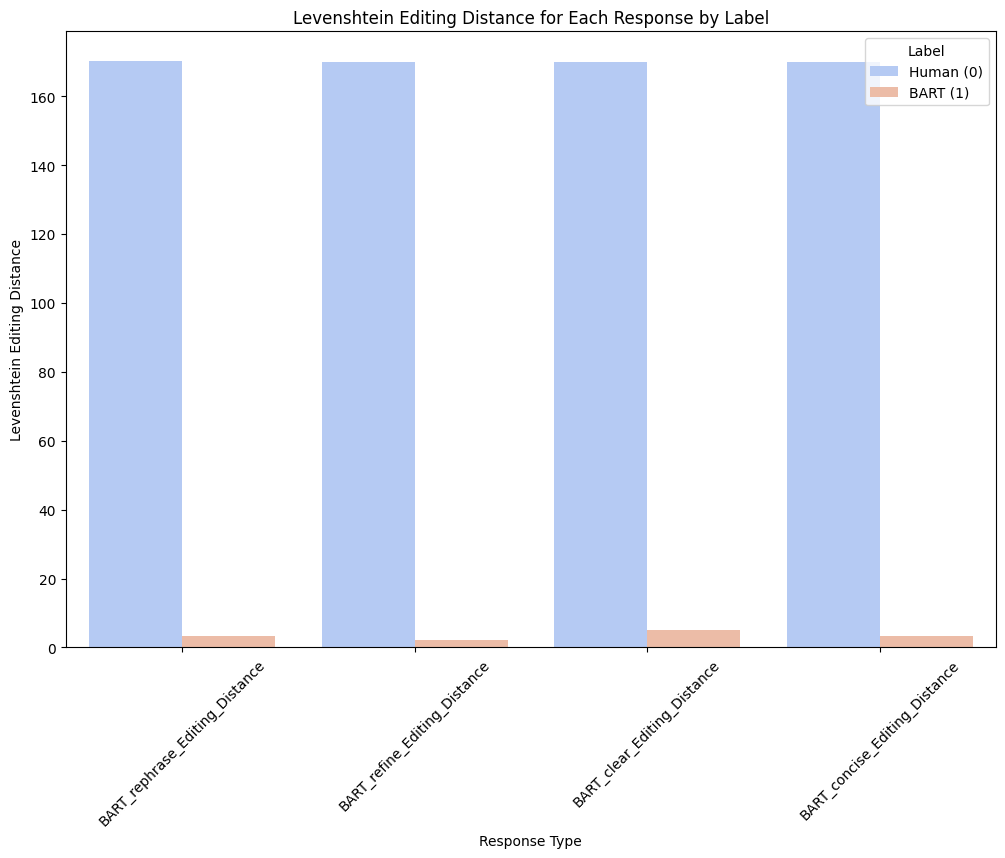

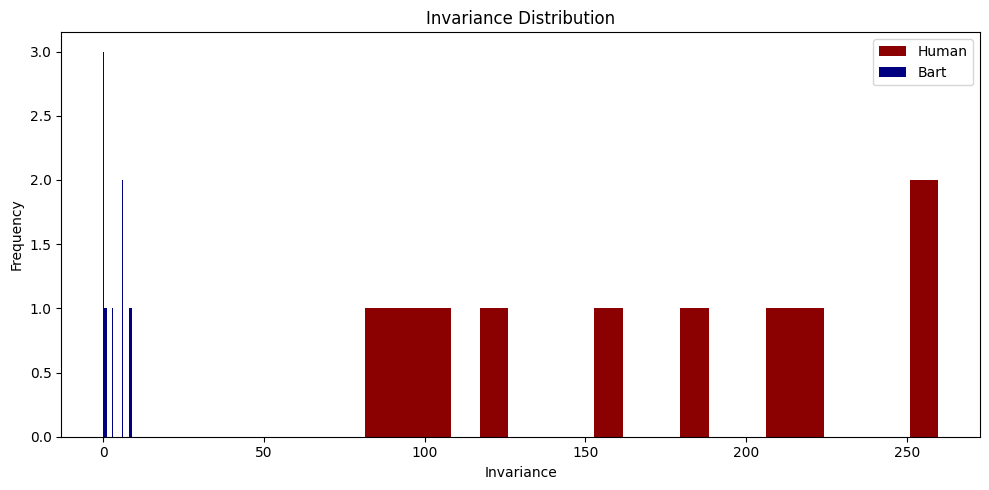

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Reshape the DataFrame for plotting
plot_df = pd.melt(combined_df, id_vars=['label'], value_vars=['BART_rephrase_Editing_Distance', 'BART_refine_Editing_Distance', 'BART_clear_Editing_Distance', 'BART_concise_Editing_Distance'],
                  var_name='Response', value_name='Editing_Distance')

plt.figure(figsize=(12, 8))
sns.barplot(x='Response', y='Editing_Distance', hue='label', data=plot_df, palette='coolwarm', errorbar=None)  
plt.xlabel('Response Type')
plt.ylabel('Levenshtein Editing Distance')
plt.title('Levenshtein Editing Distance for Each Response by Label')
plt.xticks(rotation=45)
plt.legend(title='Label', labels=['Human (0)', 'BART (1)'])
plt.show()

# Separate data based on label
human_data = combined_df[combined_df['label'] == 0]
bart_data = combined_df[combined_df['label'] == 1]

plt.figure(figsize=(10,5))  
plt.hist(human_data['Invariance'], bins=20, label='Human', color='darkred')  
plt.hist(bart_data['Invariance'], bins=20, label='Bart', color='navy')  
plt.xlabel('Invariance')  
plt.ylabel('Frequency')  
plt.title('Invariance Distribution')  
plt.legend()   
plt.tight_layout()  
plt.show()